In [1]:
#!pip install opencv-python

In [2]:
#from collections import defaultdict
#import itertools
#import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import yaml
import os
from coco import COCO
import json

In [3]:
# Read YAML file
with open("config.yaml", 'r') as stream:
    config_file = yaml.safe_load(stream)

DATASET_DIR = config_file['dataset_src_dir']
    
TRAIN_PATH = os.path.join(DATASET_DIR, config_file['train'])
VAL_PATH = os.path.join(DATASET_DIR, config_file['val'])
TEST_PATH = os.path.join(DATASET_DIR, config_file['test'])

IMAGES_PATH = os.path.join(DATASET_DIR, 'images/')

dataset_path = os.path.join(DATASET_DIR, 'coco_hurtigruten.json')
MERGE_CLASSES = True

In [4]:
if MERGE_CLASSES:
    '''
    Merge classes and remove non boat annotations
    '''
    non_boats = ['buoys', 'fish_farm']
    non_boats_id = [11, 23]
    with open(dataset_path) as stream:
        dataset_file = yaml.safe_load(stream)
    
    merged_dataset = dataset_file.copy()
    merged_dataset['annotations'] = [annot for annot in dataset_file['annotations'] if annot['category_id'] not in non_boats_id]
    for annot in merged_dataset['annotations']:
        annot['category_id'] = 0

    categories = { "supercategory": "none", "id": 0, "name": "boat" }
    merged_dataset['categories'] = [categories]

    dataset_path = os.path.join(DATASET_DIR, 'coco_hurtigruten_one_class.json')
    with open(dataset_path, 'w+') as outfile:
        json.dump(merged_dataset, outfile, indent=4)

In [5]:
#dataset_path = os.path.join(DATASET_DIR, 'coco_hurtigruten.json')
data = COCO(dataset_path)
CLASSES = {id: cat['name'] for id, cat in data.cats.items()}

creating index...
index created!


In [6]:
catIds = list(CLASSES.keys())
catIds.sort()
sorted_class_names = [CLASSES[id] for id in catIds]
dataset_info = {'path': DATASET_DIR, 'train': config_file['train'], 'val': config_file['val'], 'test': config_file['test'], 'nc': len(CLASSES), 'names': sorted_class_names}

In [7]:

# Read YAML file
with open("dataset.yaml", 'w+') as file:
    yaml.dump(dataset_info, file)

In [8]:
numb_images = len(data.imgs)
print('Number of images: ', numb_images)
numb_of_categories = len(data.cats)
print('Number of classes:', numb_of_categories)
print('Classes:', [cat['name'] for cat in data.cats.values()])

Number of images:  4994
Number of classes: 1
Classes: ['boat']


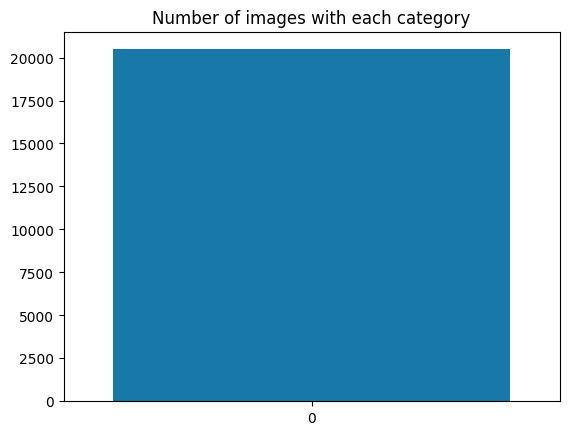

{0: 'boat'}


In [9]:
cat_stats = {id : len(imgs) for id, imgs in data.catToImgs.items()}

sns.set_palette("winter", len(cat_stats))
sns.barplot(x=list(cat_stats.keys()), y= list(cat_stats.values())).set(title='Number of images with each category')
plt.show()
print(CLASSES)


In [10]:
print('Number of annotations:', sum(list(cat_stats.values())))

Number of annotations: 20481


### Display some images

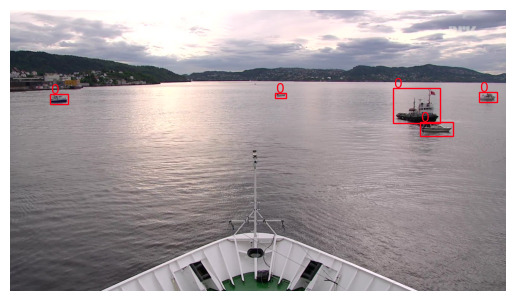

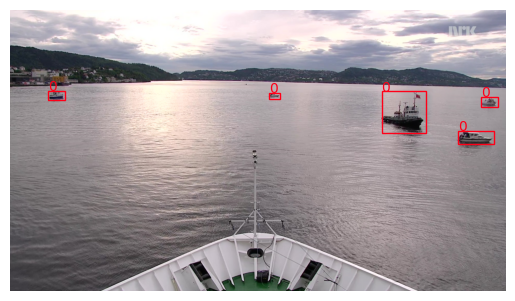

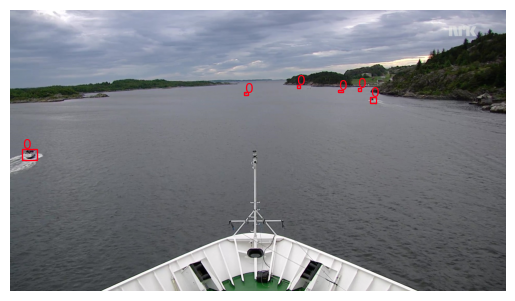

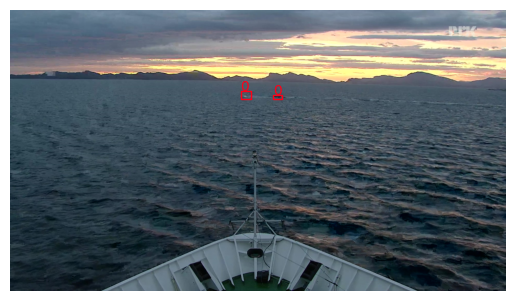

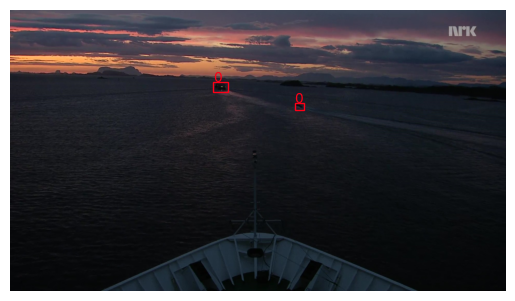

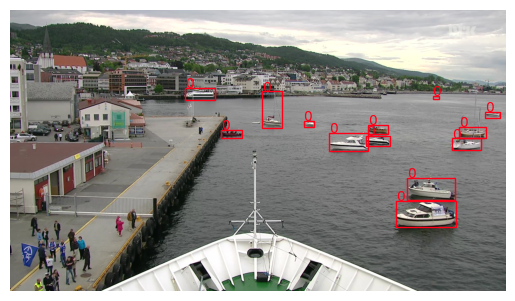

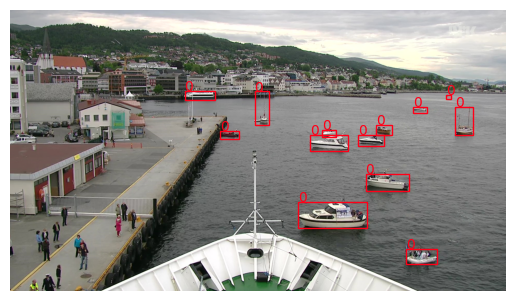

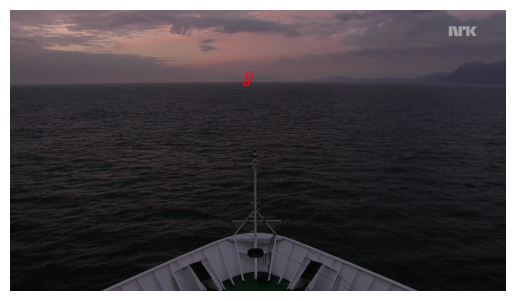

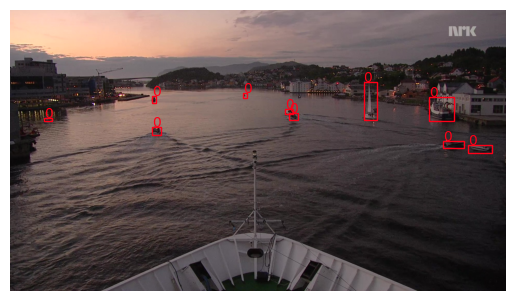

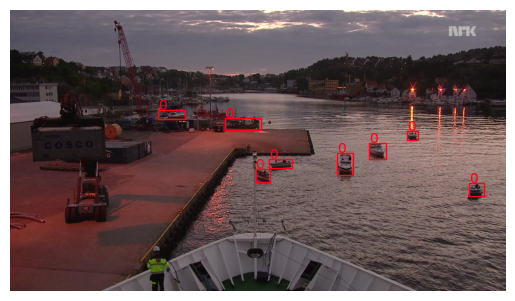

In [11]:
image_ids = [31, 32, 171, 197, 223, 367, 368, 484, 544, 553] 
#images_path = './hurtigruten/images/'

for image_id in image_ids:
    data.visualizeImage(image_id, IMAGES_PATH)

## Convert from xml to yolo format

In [12]:
from xml2yolo import xml_to_yolo

input_dir = os.path.join(DATASET_DIR, 'annotations/')
label_dir = os.path.join(DATASET_DIR , 'labels/')
image_dir = os.path.join(DATASET_DIR, 'images/')



In [13]:
sorted_class_names

['boat']

In [14]:
xml_to_yolo(input_dir, label_dir, image_dir, sorted_class_names, merge_classes=MERGE_CLASSES)

## Split into train, val and test

In [15]:
import glob
import random

files = []
for image_type in ['*.jpg', '*.jpeg', '*.png', '*.JPG']:
    files += glob.glob(os.path.join(image_dir, image_type))
random.shuffle(files)

folders = config_file['split']
check_sum = sum([folders[x] for x in folders])
assert check_sum == 1.0, "Split proportion is not equal to 1.0"

In [16]:
split_point_train = round(len(files)*folders['train'])
split_point_val = split_point_train + round(len(files)*folders['val'])


with open(TRAIN_PATH, 'w+') as file:
    file.write('\n'.join(str('./'+'/'.join(line.split('/')[-2:])) for line in files[:split_point_train]))

with open(VAL_PATH, 'w+') as file:
    file.write('\n'.join(str('./'+'/'.join(line.split('/')[-2:])) for line in files[split_point_train:split_point_val]))

with open(TEST_PATH, 'w+') as file:
    file.write('\n'.join(str(image_dir +'/'.join(line.split('/')[-1:])) for line in files[split_point_val:]))


In [17]:
print('# of train: ', split_point_train)
print('# of val: ', str(split_point_val-split_point_train))
print('# of test: ', str(len(files)-split_point_val))

# of train:  3496
# of val:  749
# of test:  749


## Move test images into folder

In [18]:
#import shutil

In [19]:
#testImages = os.path.join(DATASET_DIR, 'testImages/')
#os.mkdir(testImages)

In [20]:
#with open(TEST_PATH, 'r') as file:
#    for line in file.readlines():
#        line = line.rstrip()
#        image_name = line.split('/')[-1]
#        new_path = os.path.join(testImages,image_name)
#        shutil.move(line, new_path)

In [21]:
# new_image_dir = os.path.join(DATASET_DIR, 'testImages/')
# with open(TEST_PATH, 'w+') as file:
#     file.write('\n'.join(str(new_image_dir +'/'.join(line.split('/')[-1:])) for line in files[split_point_val:]))